In [68]:
%matplotlib inline
import os

import collections

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from seaplotlib.helper import abline, despine, save_fig_in_dir, styles

In [39]:
INSERTIONS = '0.5.21.filtered_calls_prosgfp_guts.gff'
LABEL = "ProsGFP calls guts"
IMAGE_EXTENSION = 'pdf'
SAMPLE_FILE = 'ProsGFP_tumor_samples.csv'

In [40]:
def get_insertions(path):
    insertions = []
    with open(path) as f:
        for line in f:
            fields = line.split('\t')
            insertions.append({'start': int(fields[3]),
                               'end': int(fields[4]),
                               'class': fields[2], 
                               'score': int(fields[5]), 
                               'nref': int(fields[8].split(';')[7].split('=')[1].split('_')[0]), 
                               'sample': fields[8].split(';')[0].split('=')[1].split('_')[0]})
    insertions = pd.DataFrame.from_records(insertions)
    return insertions


def transform_summary(insertions):
    g = insertions.groupby(['class', 'sample'])
    s = g.aggregate('class').count()
    ins_df = s.to_frame()
    ins_df.columns = ['count']
    ins_df = ins_df.reset_index()
    return ins_df



def fill_missing_with_zero(df, all_sample_list):
    for sample in all_sample_list:
        if sample not in df['sample'].unique():
            if 'class' in df:
                for kls in df['class'].unique():
                    entry = {0: {'class': kls, 'sample': sample, 'count': 0}}
                    df = df.append(pd.DataFrame.from_dict(entry, orient='index'))
            else:
                entry = {0: {'sample': sample, 'count': 0}}
                df = df.append(pd.DataFrame.from_dict(entry, orient='index'))
    return df

            
def insertions_per_sample(df, color='r', title=None, all_sample_list=None):
    if all_sample_list is not None:
        df = fill_missing_with_zero(df, all_sample_list)
    df = df.sort_values('count', ascending=False)
    ax = despine(df.plot(kind='bar', x='sample', y='count', color=color, figsize=(8, 5), legend=False, title=title))
    mean = df['count'].mean()
    max_y = df['count'].max()
    abline(slope=0, intercept=mean)
    x = len(df['sample'].unique())
    x = x - x / 8  # 12,5 % from the right
    y = mean + max_y / 50  # 2 % of the y + mean position
    ax.annotate('Mean=%.2f' % mean, (x, y))
    return ax

In [45]:
def plot_insertions(ins_df, all_sample_list, suffix=''):
    all_insertions = ins_df.groupby(['sample']).sum().reset_index()
    rover_insertions = ins_df[ins_df['class'] == 'rover']
    copia_insertions = ins_df[ins_df['class'] == 'copia']
    i_element_insertions = ins_df[ins_df['class'] == 'I-element']

    kwargs = {
        'All insertions': [all_insertions, 'r'],
        'Rover insertions': [rover_insertions, 'k'],
        'Copia insertions': [copia_insertions, 'b'],
        'I-element insertions': [i_element_insertions, 'g'],
    }
    kwargs = {k: v for k, v in kwargs.items() if len(v[0]) > 0}

    for title, args in kwargs.items():
        title = "%s per sample" % title
        f = insertions_per_sample(all_sample_list=all_sample_list, title=title, *args).figure
        save_fig_in_dir(f, "%s%s.%s" % (title, suffix, IMAGE_EXTENSION), directory=LABEL, bbox_inches='tight')


with open(SAMPLE_FILE) as fh:
    SAMPLES = fh.read().strip().split(',')
insertions = get_insertions(INSERTIONS)
ins_df = transform_summary(insertions)
plot_insertions(ins_df, SAMPLES, suffix=' %s' % LABEL)

NameError: name 'SAMPLES' is not defined

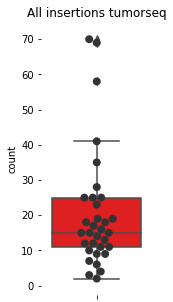

In [34]:
# overview boxplot

fig, ax = plt.subplots(figsize=(2, 5))
bp_data = ins_df.groupby(['sample']).sum().reset_index()
sns.boxplot(y='count', hue="sample", ax=ax, data=bp_data, color='r')
despine(sns.swarmplot(y='count', hue="sample", ax=ax, data=bp_data, color="0.2", size=8))
ax.set_title('All insertions tumorseq')
save_fig_in_dir(fig, 'all_insertions_all_samples.%s' % IMAGE_EXTENSION, directory=LABEL, bbox_inches='tight')

In [31]:
ins_df.groupby(['sample']).sum().reset_index()

,sample,count
0,H1,19
1,H4,70
2,H7,69
3,R1,16
4,R11,25
5,R13,25
6,R17,6
7,R19,2
8,R21,4
9,R23,13


In [32]:
def plot_with_broken_axis(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
    df.plot(kind='bar', ax=ax1, color='r')
    df.plot(kind='bar', ax=ax2, color='r')
    ax1.set_ylim(400, 500.)  # outliers only
    ax2.set_ylim(0, 100)  # most of the data
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    # ax1.xaxis.tick_top()
    ax1.xaxis.set_ticks_position('none') 

    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    # plt.xticks(rotation=45)
    ax2.xaxis.tick_bottom()

    d = 0.015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    rects = ax2.patches
    # # Make some labels.
    labels = df.values

    for rect, label in zip(rects, labels):
        if label > 120:
            ax = ax1
        else:
            ax = ax2
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom')
    return fig

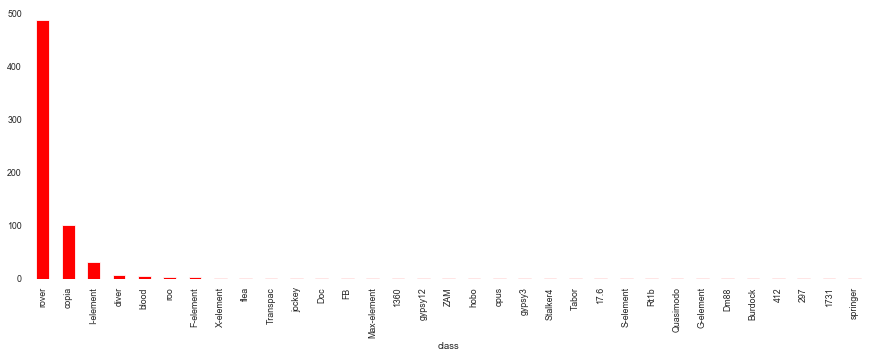

In [33]:
class_overview = ins_df.groupby('class').sum().sort_values('count', ascending=False).unstack().reset_index()
class_overview.index = class_overview['class']
# fig = plot_with_broken_axis(class_overview[0])
fig = despine(class_overview[0].plot(kind='bar', color='red', figsize=(15,5)))
save_fig_in_dir(fig.figure, 'transposon classes %s.%s' % (LABEL, IMAGE_EXTENSION), directory=LABEL, bbox_inches='tight')

In [34]:
class_overview.columns = ['kind', 'class', 'count']
class_overview['count']

class
rover          487
copia          102
I-element       32
diver            7
blood            5
roo              4
F-element        4
X-element        2
flea             2
Transpac         2
jockey           2
Doc              2
FB               2
Max-element      2
1360             1
gypsy12          1
ZAM              1
hobo             1
opus             1
gypsy3           1
Stalker4         1
Tabor            1
17.6             1
S-element        1
Rt1b             1
Quasimodo        1
G-element        1
Dm88             1
Burdock          1
412              1
297              1
1731             1
springer         1
Name: count, dtype: int64

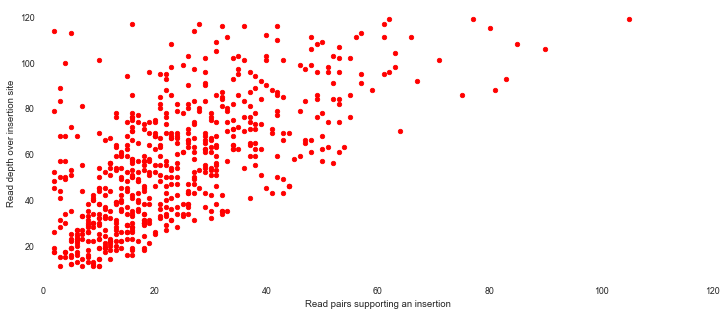

In [35]:
insertions = get_insertions(INSERTIONS)
insertions['total'] = insertions['nref'] + insertions['score']
total = insertions.sort_values('total')
total_above_10 = total[(total['total'] > 10) & (total['total'] < 120)]
ax = despine(total_above_10.plot(kind='scatter', x='score', y='total', xlim=(0, 120), color='red', figsize=(12, 5)))
ax.set_xlabel('Read pairs supporting an insertion')
ax.set_ylabel('Read depth over insertion site')
save_fig_in_dir(ax.figure, 'transposon classes Read support per insertion %s.%s' % (LABEL, IMAGE_EXTENSION), directory=LABEL, bbox_inches='tight')

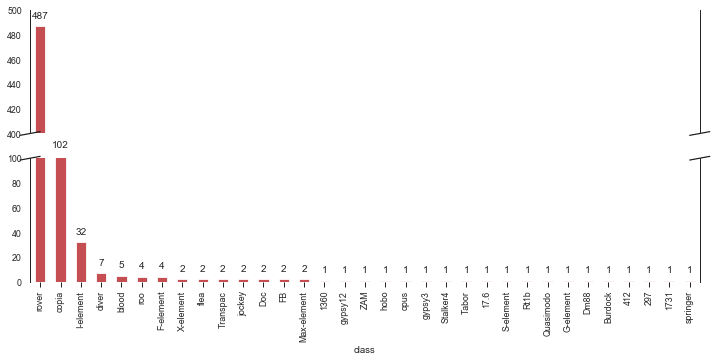

In [36]:
class_overview = ins_df.groupby('class').sum().sort_values('count', ascending=False).unstack().reset_index()
class_overview.index = class_overview['class']
fig = plot_with_broken_axis(class_overview[0])
save_fig_in_dir(fig, 'transposon classes broken axis %s.%s' % (LABEL, IMAGE_EXTENSION), directory=LABEL, bbox_inches='tight')

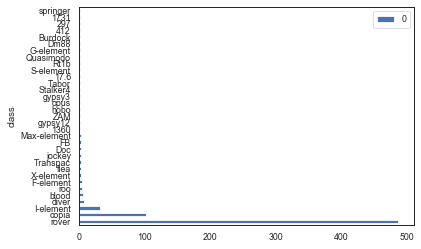

In [37]:
class_overview.plot(y=0, kind='barh', stacked=True)

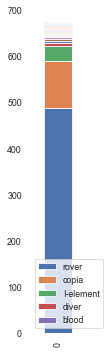

In [38]:
sns.set(context='paper', style="white")
fig, ax = plt.subplots(figsize=(1, 6))
class_overview[0].reset_index().set_index('class').sort_values(by=0, ascending=False).T.plot(kind='bar', label=['rover', 'copia', 'I-element', 'blood'], stacked=True, ax=ax)
h, l = ax.get_legend_handles_labels()
plt.legend(h[:5], l[:5])
despine(ax)
save_fig_in_dir(fig, 'te_family_stacked_barplot %s.%s' % (LABEL, IMAGE_EXTENSION), directory=LABEL, bbox_inches='tight')

In [39]:
df = class_overview[0].reset_index().set_index('class').sort_values(by=0, ascending=False)

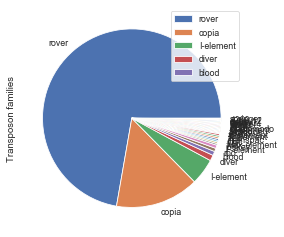

In [40]:
sns.set(context='paper', style="white")
fig, ax = plt.subplots(figsize=(4, 6))
df.plot(y=0, kind='pie', label="Transposon families", ax=ax)
h, l = ax.get_legend_handles_labels()
plt.legend(h[:5], l[:5])
despine(ax)
save_fig_in_dir(fig, 'te_family_stacked_pie_plot %s.%s' % (LABEL, IMAGE_EXTENSION), directory=LABEL, bbox_inches='tight')

In [41]:
ins_df

,class,sample,count
0,1360,R59,1
1,17.6,H7,1
2,1731,R39,1
3,297,R11,1
4,412,H1,1
...,...,...,...
126,rover,R59,6
127,rover,R61,5
128,rover,R63,8
129,rover,R9,38


In [49]:
insertions['tsd_len'] = insertions['end'] - insertions['start']

In [50]:
# this one is bizarre, shouldn't be a TSD element
insertions = insertions[insertions['tsd_len'] != 0]

In [55]:
tsd_df = insertions[['class', 'tsd_len']]
tsd_df.columns = ['Transposable Element', 'TSD length']

In [69]:
tsd_df.to_csv(os.path.join(LABEL, 'TSD lengths.csv'))

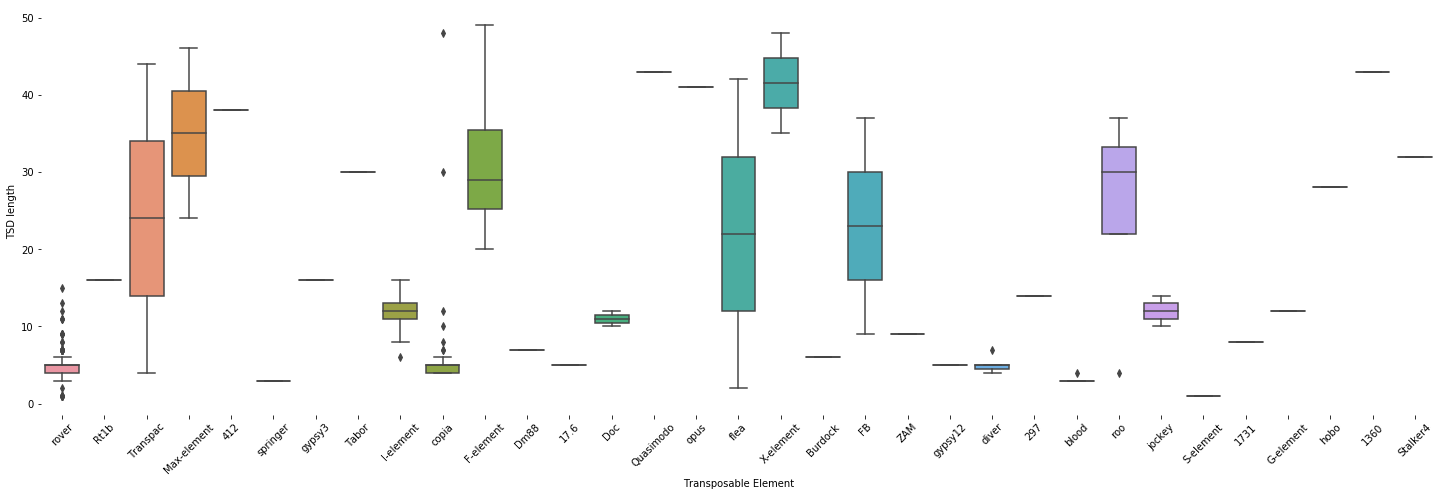

In [62]:
fig, ax = plt.subplots(figsize=(25, 7.5))
sns.boxplot(y='TSD length', x='Transposable Element', data=tsd_df, ax=ax)
ax = plt.gca()
despine(ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
save_fig_in_dir(fig, 'TSD_length_boxplot.pdf %s.%s' % (LABEL, IMAGE_EXTENSION), directory=LABEL, bbox_inches='tight')

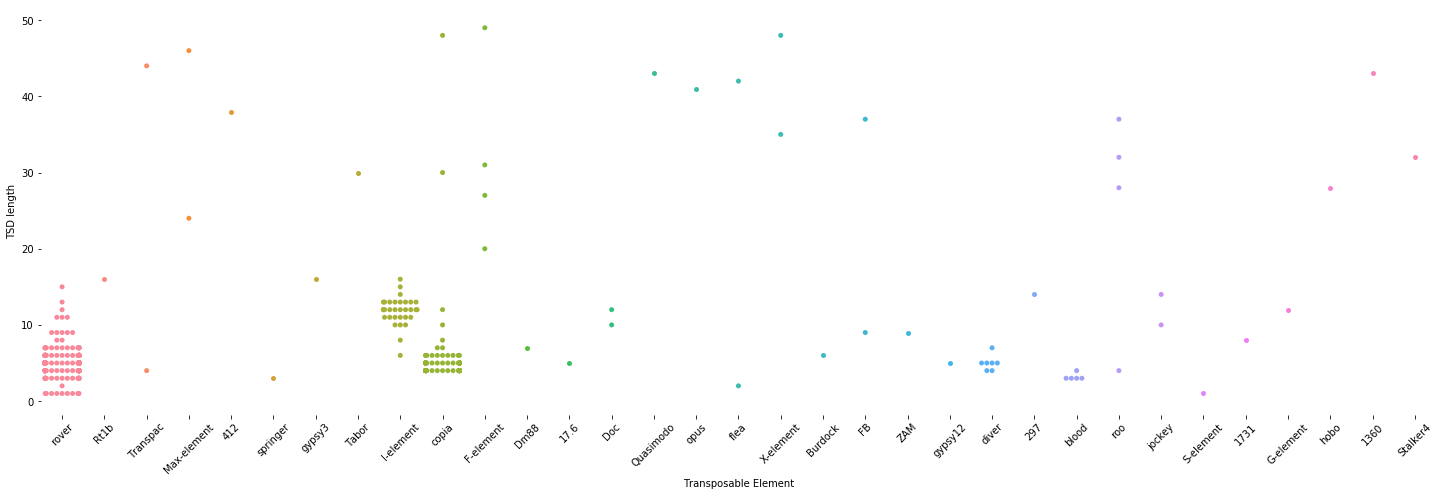

In [63]:
fig, ax = plt.subplots(figsize=(25, 7.5))
sns.swarmplot(y='TSD length', x='Transposable Element', data=tsd_df, ax=ax)
ax = plt.gca()
despine(ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
save_fig_in_dir(fig, 'TSD_length_swarmplot.pdf %s.%s' % (LABEL, IMAGE_EXTENSION), directory=LABEL, bbox_inches='tight')